In [7]:
import pandas as pd
import numpy as np

import pingouin as pg

import scipy.stats as ss
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

import matplotlib.pyplot as plt
import seaborn as sns

### Dataset 5_task_1.csv
В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные

In [45]:
df_1 = pd.read_csv('5_task_1.csv')

#### Задание 1
Итак, первая задача: нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

A – прямоугольные 16:9
B – квадратные
C – прямоугольные 12:4
Каким статистическим тестом нужно воспользоваться для сравнения средних в данном случае?

<AxesSubplot:xlabel='group', ylabel='events'>

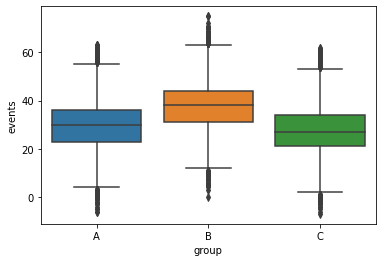

In [5]:
sns.boxplot(data=df_1, x='group', y='events')

In [41]:
pg.anova(data=df_1, dv="events", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


#### Задание 2
Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

Hint: scipy.stats.levene либо pingouin.homoscedasticity

In [6]:
pg.homoscedasticity(data=df_1, dv='events', group='group')

,W,pval,equal_var
levene,2.26226,0.104133,True


#### Задание 3
Также убедитесь, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность обязательно сделайте семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты. Для воспроизводимости результата используйте параметр random_state=17 в методе sample.

Дополнительно: попробуйте посчитать тест Шапиро-Уилка без использования метода sample. Сравните  результат с normaltest, а также qq-графиками. Какой вывод можно сделать по совокупности этих методов?

Выберите верные утверждения:
* Все утверждения не верны
* **Распределение events в группе A является нормальным**
* **Распределение events в группе B является нормальным**
* **Распределение events в группе С является нормальным**

In [13]:
events_1_A = df_1.query('group == "A"').events
events_1_B = df_1.query('group == "B"').events
events_1_C = df_1.query('group == "C"').events

In [14]:
print('Без сэплирования:')
print(ss.shapiro(events_1_A))
print(ss.shapiro(events_1_B))
print(ss.shapiro(events_1_C))

Без сэплирования:
ShapiroResult(statistic=0.9989418387413025, pvalue=4.318870651331963e-06)
ShapiroResult(statistic=0.9990161061286926, pvalue=1.0504894817131571e-05)
ShapiroResult(statistic=0.9989210963249207, pvalue=3.3885160064528463e-06)


c:\Users\psyrnev\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [15]:
df_1_sample = df_1.sample(1000, random_state=17)
events_1_A = df_1_sample.query('group == "A"').events
events_1_B = df_1_sample.query('group == "B"').events
events_1_C = df_1_sample.query('group == "C"').events

In [16]:
print('С применением сэплирования:')
print(ss.shapiro(events_1_A))
print(ss.shapiro(events_1_B))
print(ss.shapiro(events_1_C))

С применением сэплирования:
ShapiroResult(statistic=0.9929315447807312, pvalue=0.1330225169658661)
ShapiroResult(statistic=0.9900172352790833, pvalue=0.027956675738096237)
ShapiroResult(statistic=0.9954989552497864, pvalue=0.39249300956726074)


In [17]:
#другой вариант

print(ss.normaltest(events_1_A))
print(ss.normaltest(events_1_B))
print(ss.normaltest(events_1_C))

NormaltestResult(statistic=0.11146211192767554, pvalue=0.9457934672008635)
NormaltestResult(statistic=7.046494540829163, pvalue=0.02950347368854365)
NormaltestResult(statistic=0.32139646434474867, pvalue=0.8515490024309781)


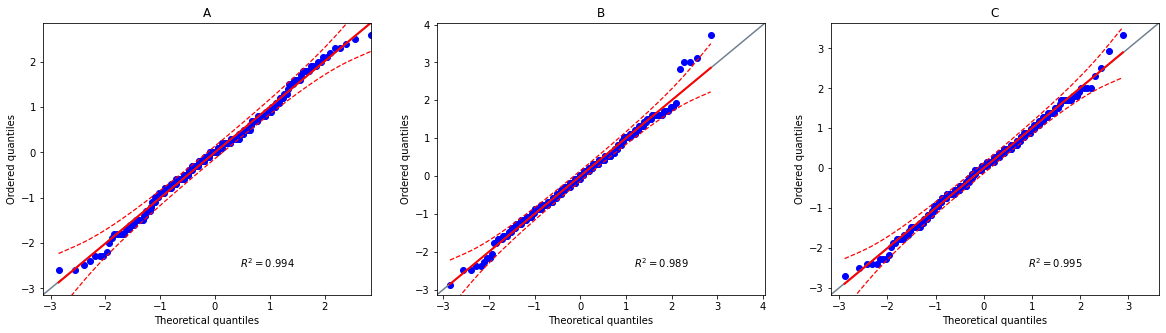

In [28]:
fig, axis = plt.subplots(ncols=3, nrows=1)
fig.set_figwidth(20)
fig.set_figheight(5)

pg.qqplot(events_1_A, ax=axis[0])
pg.qqplot(events_1_B, ax=axis[1])
pg.qqplot(events_1_C, ax=axis[2])

axis[0].title.set_text('A')
axis[1].title.set_text('B')
axis[2].title.set_text('C')

#### Задание 4
Для сравнения средних я использую **ОДНОФАКТОРНЫЙ ДИСПЕРСИОННЫЙ АНАЛИЗ**. Значение статистики равно (окр. до целого) **2886**, а р-уровень значимости составил **0**.

In [30]:
events_1_A = df_1.query('group == "A"').events
events_1_B = df_1.query('group == "B"').events
events_1_C = df_1.query('group == "C"').events
ss.f_oneway(events_1_A, events_1_B, events_1_C)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

#### Задание 5
Теперь используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 

Дополнительно: попробуйте другие варианты поправок на множественные сравнения через pingouin. Дают ли они те же выводы, что и Тьюки?
* **B и C**
* Нет значимых
* **A и C**
* **A и B**

Effect size type. Available methods are:
* 'none': no effect size
* 'cohen': Unbiased Cohen d
* 'hedges': Hedges g
* 'r': Pearson correlation coefficient
* 'eta-square': Eta-square
* 'odds-ratio': Odds ratio
* 'AUC': Area Under the Curve
* 'CLES': Common Language Effect Size

In [34]:
pg.pairwise_tukey(data=df_1, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.018089


In [40]:
effsizes = {
    'none': 'no effect size',
    'cohen': 'Unbiased Cohen d',
    'hedges': 'Hedges g',
    'r': 'Pearson correlation coefficient',
    'eta-square': 'Eta-square',
    'odds-ratio': 'Odds ratio',
    'AUC': 'Area Under the Curve',
    'CLES': 'Common Language Effect Size'
}

for e in effsizes:
    pv = pg.pairwise_tukey(data=df_1, dv="events", between="group", effsize=e)['p-tukey'].to_list()
    print(f'{e} - {effsizes[e]}\n\t\t p-values: {pv}')

none - no effect size
		 p-values: [0.0, 0.0, 0.0]
cohen - Unbiased Cohen d
		 p-values: [0.0, 0.0, 0.0]
hedges - Hedges g
		 p-values: [0.0, 0.0, 0.0]
r - Pearson correlation coefficient
		 p-values: [0.0, 0.0, 0.0]
eta-square - Eta-square
		 p-values: [0.0, 0.0, 0.0]
odds-ratio - Odds ratio
		 p-values: [0.0, 0.0, 0.0]
AUC - Area Under the Curve
		 p-values: [0.0, 0.0, 0.0]
CLES - Common Language Effect Size
		 p-values: [0.0, 0.0, 0.0]


#### Задание 6

Так какие картинки в итоге будем использовать?
* C – Прямоугольные, 12:4
* **B – Квадратные**
* A – Прямоугольные, 16:9

<AxesSubplot:xlabel='group', ylabel='events'>

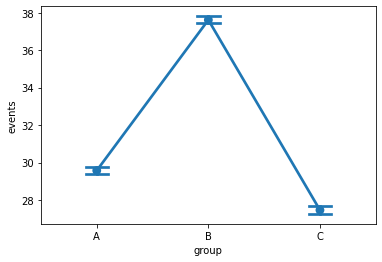

In [60]:
sns.pointplot(data=df_1, x='group', y='events', capsize=0.2)

### Dataset 5_task_2.csv
Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый

Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

In [44]:
df_2 = pd.read_csv('5_task_2.csv')

#### Задание 7
Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

Какой метод скорее всего пригодится в данном случае?
* **многофакторный дисперсионный анализ**
* хи-квадрат
* t-test
* однофакторный дисперсионный анализ

In [47]:
df_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


#### Задание 8

Посмотрим на данные. Для начала визуализируйте распределение events для контрольной и тестовой групп. Соотнесите графики распределения и экспериментальные группы:

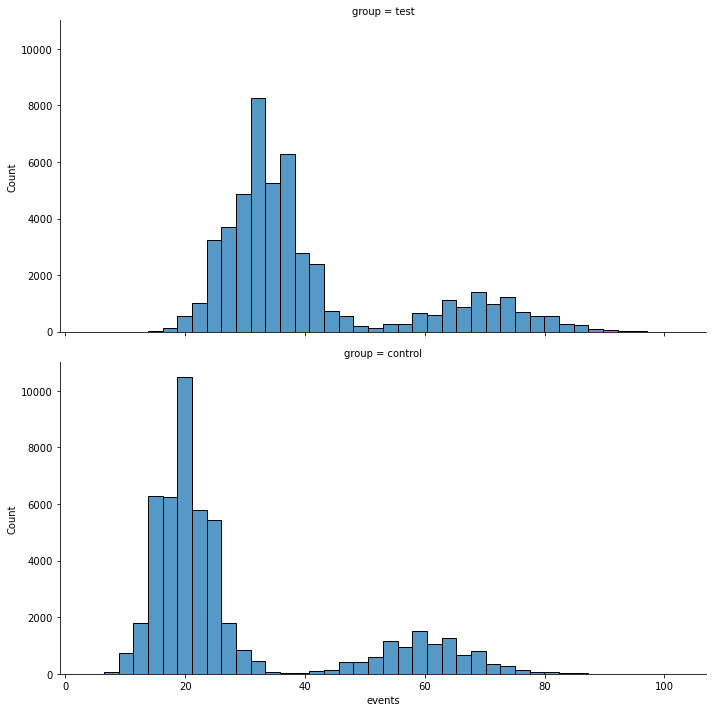

In [53]:
# fig, axis = plt.subplots(nrows=1, ncols=2)

sns.displot(data=df_2, x='events', row='group', aspect=2, bins=40)


#### Задание 8
Посчитайте среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

В качестве ответа укажите стандартное отклонение для пользователей из сегмента high и контрольной группы, с точностью до 2 знаков после точки.

In [54]:
df_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [56]:
df_2.groupby(by=['group','segment']).events.describe().round(2)

count   mean   std   min   25%   50%   75%    max
group   segment                                                     
control high     10000.0  59.97  7.81  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.03  4.47   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.94  8.40  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.03  5.72  13.0  29.0  33.0  37.0   59.0

#### Задание 9
Почти у цели – осталось выбрать формулу для модели. Напомним, что мы хотим проверить эффект нескольких переменных – group и segment – на events, с взаимодействием факторов.

Если вы прибегнете к statsmodels, то какую формулу используете?

* events = segment + group + segment:group
* **events ~ segment + group + segment:group**
* **events ~ segment + segment*group**
* events ~ segment, group
* events = segment + group
* events ~ segment + group

#### Задание 10
Проведите тест (через anova_lm либо pg.anova), а затем используйте критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

В данном случае для последующих сравнений между группами можно проделать следующую операцию: соединить колонки group и segment в combination, чтобы потом передать в аргумент groups в MultiComparison либо pairwise_tukey:

<pre>
+-------+---------+-------------+
| group | segment | combination |
+-------+---------+-------------+
| test  | high    | test / high |
| test  | high    | test / high |
+-------+---------+-------------+
</pre>
Между какими группами были обнаружены статистически значимые различия? Выберите верные утверждения:

Note:  При интерпретации обратите внимание на то, какая из групп с какой сравнивается и как считается meandiff.

* **Для обоих сегментов показатели статистически значимо _увеличились_ по сравнению с контрольной группой**
* Для обоих сегментов показатели статистически значимо _уменьшились_ по сравнению с контрольной группой
* Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 36
* **Разница между control/high и test/high составила около 10**
* Различий совсем не оказалось :(
* **Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13**

In [62]:
model = smf.ols(formula = "events ~ C(group)*C(segment)", data = df_2).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
C(segment),1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
C(group):C(segment),1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


In [63]:
df_2['combination'] = df_2.group + ' / ' + df_2.segment

In [78]:
pg.pairwise_tukey(data=df_2, dv='events', between='combination') \
    .sort_values(by=['A','diff'], ascending=False)
    # .query('A == "control / low" and B == "test / low" or A == "control / high" and B == "test / high"')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
5,test / high,test / low,69.938500,33.025925,36.912575,0.065432,564.135148,0.0,6.307128
4,control / low,test / low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.0,-2.220314
3,control / low,test / high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.0,-8.527429
0,control / high,control / low,59.970800,20.031575,39.939225,0.065432,610.391461,0.0,6.824282
2,control / high,test / low,59.970800,33.025925,26.944875,0.065432,411.798717,0.0,4.603981
1,control / high,test / high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.0,-1.703109


#### Задание 11
Визуализируйте результаты теста и заполните пропуски:

Фактор group оказался **ЗНАЧИМЫМ**, фактор segment – **ЗНАЧИМЫМ**, их взаимодействие –**ЗНАЧИМО**. Судя по графику, для всех групп среднее значение events **УВЕЛИЧИЛОСЬ**, поэтому решение: **ВЫКАТЫВАЕМ НОВУЮ ВЕРСИЮ**.

<AxesSubplot:xlabel='group', ylabel='events'>

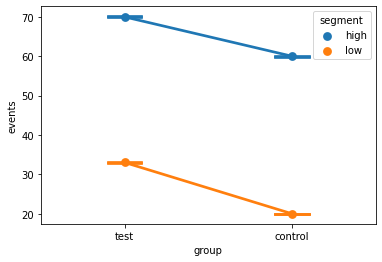

In [79]:
sns.pointplot(data=df_2, y="events", x="group", hue="segment", capsize=0.2)